In [98]:
# 📌 외부 py 파일 수정 시 자동으로 재로드되도록 설정
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
# ================================================
# 📦 공통 패키지 import
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import sys

# src 경로 추가
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# seaborn 스타일 설정
sns.set(style="whitegrid")

# ================================================
# ⚙️ 경로 및 상수 설정
# ================================================
DATA_DIR = "../data/processed"
OUTPUT_DIR = "../data/modeling"
SEOUL_STATION_PATH = os.path.join(DATA_DIR, "seoul_env_station_mapped.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# KMeans 설정
KMEANS_MODE = "auto" # auto, manual
KMEANS_MANUAL_K = 5

# XGBoost 설정
XGB_N_ESTIMATORS = 100

# MCLP 설정
COVERAGE_RADIUS = 0.005
FACILITY_LIMIT = 30

# ================================================
# 🧪 평가 함수 import
# ================================================
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# ================================================
# 🧠 모델 함수 import
# ================================================
from modeling.kmeans_model import run_kmeans

# K means

In [121]:
# 데이터 로드
grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")

# 수요가 가장 높은 클러스터만 추출
grid = run_kmeans(
    grid,
    mode=KMEANS_MODE,
    # manual_k=KMEANS_MANUAL_K,
    return_top_cluster_only=True
)

Finding optimal k:   0%|          | 0/9 [00:00<?, ?it/s]

Finding optimal k: 100%|██████████| 9/9 [00:00<00:00, 20.53it/s]

[AUTO MODE] 최적 k = 2
Inertia by k: {2: 394878040.6060905, 3: 182752136.7917526, 4: 111630868.37625773, 5: 83130803.13068569, 6: 65292788.3815513, 7: 54917904.7908943, 8: 48181642.39693806, 9: 36633734.731904596, 10: 32347245.131689377}

[Cluster별 평균 수요]
cluster
1    1360.575095
0      57.366915
Name: demand_score, dtype: float64

[필터링] 수요가 가장 높은 클러스터 (cluster=1)만 반환됨.


In [122]:
# 필요한 컬럼만 유지 (grid: KMeans 결과)
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]

# 원본 feature 로드
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")

# 병합 전: features_all 좌표 제거 (혼동 방지)
features_all = features_all.drop(columns=['center_lat', 'center_lon'], errors='ignore')

# 병합
features = features_all.merge(grid, on='grid_id', how='inner')

# cluster 정수형 처리
features['cluster'] = features['cluster'].astype(int)

# 저장 전 좌표 정리: 이미 이름이 정돈돼 있음
# → center_lat, center_lon 이 grid 기준으로만 존재
features = features.loc[:, ~features.columns.duplicated()]  # 혹시 모를 중복 제거

# 저장
features.to_csv(f"{DATA_DIR}/filtered_cluster_features.csv", index=False)
print("✅ 좌표 컬럼 중복 없이 정리 및 저장 완료")

# 확인
print(f"전체 feature 수: {len(features_all)}")
print(f"수요 밀집 클러스터 feature 수: {len(features)}")
print(f"병합 후 유지된 비율: {len(features) / len(features_all) * 100:.2f}%")
print(f"사용 가능한 feature 컬럼: {features.columns.tolist()}")

✅ 좌표 컬럼 중복 없이 정리 및 저장 완료
전체 feature 수: 6030
수요 밀집 클러스터 feature 수: 526
병합 후 유지된 비율: 8.72%
사용 가능한 feature 컬럼: ['grid_id', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'center_lat', 'center_lon', 'cluster']


## 서울 전체 (회색) - 수요 (빨간색)

In [ ]:
import folium
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

# 경로 설정
ALL_FEATURES_PATH = f"{DATA_DIR}/grid_features.csv"
FILTERED_FEATURES_PATH = f"{DATA_DIR}/filtered_cluster_features.csv"

# 데이터 로드
all_features = pd.read_csv(ALL_FEATURES_PATH)
filtered_features = pd.read_csv(FILTERED_FEATURES_PATH)

# 고유 클러스터 목록 추출
unique_clusters = sorted(filtered_features['cluster'].unique())
num_clusters = len(unique_clusters)

# 클러스터별 색상 매핑 (colormap으로)
colormap = cm.get_cmap('Set1', num_clusters)
cluster_colors = {
    cluster: colors.to_hex(colormap(i))
    for i, cluster in enumerate(unique_clusters)
}

# 지도 생성
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 전체 격자 (회색)
for _, row in all_features.iterrows():
    folium.CircleMarker(
        location=[row["center_lat"], row["center_lon"]],
        radius=2,
        color='gray',
        fill=True,
        fill_opacity=0.2
    ).add_to(seoul_map)

# 필터링된 클러스터 (색상 다르게)
for _, row in filtered_features.iterrows():
    cluster = row["cluster"]
    color = cluster_colors.get(cluster, 'blue')  # fallback
    folium.CircleMarker(
        location=[row["center_lat"], row["center_lon"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.9
    ).add_to(seoul_map)

# 저장
seoul_map.save(f"../outputs/maps/cluster_colored_visualization.html")
print("✅ 클러스터별 색상 지도 저장 완료: cluster_colored_visualization.html")

/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1131/3148375791.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set1', num_clusters)


✅ 클러스터별 색상 지도 저장 완료: cluster_colored_visualization.html


# XGBoost

결측치 제거 후 학습 데이터 수: 526
📊 XGBoost 성능:
MAE: 51.13
RMSE: 81.49
R²: 0.9826


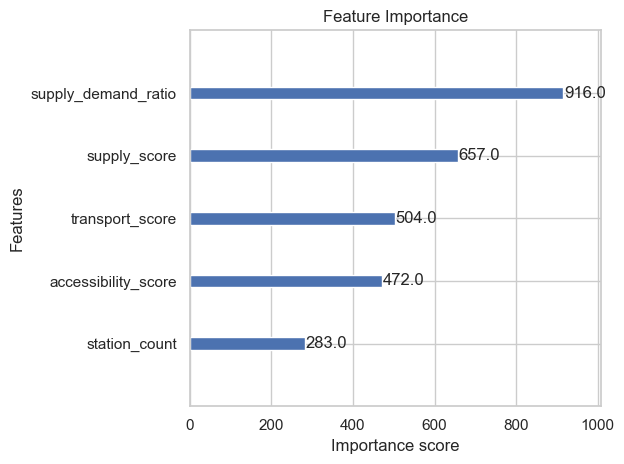

In [123]:
from modeling.xgboost_model import train_and_predict

# 🔍 성능 향상을 위한 feature 확장
selected_features = [
    'supply_score', 'station_count', 'commercial_count',
    'supply_demand_ratio', 'population_density',
    'accessibility_score', 'transport_score',
    'cluster'
]

# 결측치 로그
valid_rows = features.dropna(subset=selected_features + ['demand_score'])
print(f"결측치 제거 후 학습 데이터 수: {len(valid_rows)}")

# XGBoost 학습 및 예측
features, metrics = train_and_predict(
    df=features,
    features=selected_features,
    label='demand_score',                # ← 기존 target_column -> label로 바뀜
    n_estimators=XGB_N_ESTIMATORS,
    verbose=True                         # ← 성능 지표와 중요도 시각화 보기
)

# 예측 결과 존재 여부 확인
assert 'predicted_demand_score' in features.columns, "예측 결과 칼럼 누락"

# 저장
features.to_csv(f"{DATA_DIR}/grid_features_with_prediction.csv", index=False)
pd.DataFrame([metrics]).to_csv(f"{OUTPUT_DIR}/xgboost_metrics.csv", index=False)


# MCLP

In [136]:
from modeling.mclp_model import run_sensitivity_analysis

sensitivity_df = run_sensitivity_analysis(
    df=features,
    coverage_radii_km=[COVERAGE_RADIUS * 111],  # 현재 반경 0.005 degree ≒ 약 0.55km
    facility_limits = list(range(20, 101, 10)), # 50개 ~ 100개까지 10 단위로 실험
    demand_column='predicted_demand_score',
    verbose=True
)

# ✅ 총 커버 수요가 가장 큰 조합을 선택
best_row = sensitivity_df.loc[sensitivity_df['covered_demand'].idxmax()]

best_radius = best_row['coverage_radius_km']
best_limit = best_row['facility_limit']

print(f"\n📌 최적 반경: {best_radius}km")
print(f"📌 최적 설치 수: {best_limit}개 (설치 효율: {best_row['installation_efficiency']})")



📌 반경 0.555km, 설치 20개 시나리오 실행 중...


🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26618.29it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/1aecdaae47e5472a9ba63c5d2be95f76-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/1aecdaae47e5472a9ba63c5d2be95f76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 206375 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 46 integers unsatisfied sum - 15.2667
Cbc0038I Pass   1: suminf.    1.33333 (4) obj. -197699 iteratio

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26884.60it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/269fbd0d355742798795810ac36438fa-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/269fbd0d355742798795810ac36438fa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 275612 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 51 integers unsatisfied sum - 13.8182
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -270146 iteratio

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26692.36it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/e8700f3dc5724ba6a5dce85cbbb11d47-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/e8700f3dc5724ba6a5dce85cbbb11d47-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 332162 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 54 integers unsatisfied sum - 12.4667
Cbc0038I Pass   1: suminf.    3.66667 (11) obj. -327549 iterati

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 25805.67it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/8e69b78c5e03411fb04367d477811128-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/8e69b78c5e03411fb04367d477811128-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 381146 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 101 integers unsatisfied sum - 29.4167
Cbc0038I Pass   1: suminf.    5.66667 (19) obj. -373429 iterat

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26390.95it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/74e2066afe5b4513946f4c8cbd2f10b8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/74e2066afe5b4513946f4c8cbd2f10b8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 425247 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 124 integers unsatisfied sum - 37.6818
Cbc0038I Pass   1: suminf.    4.00000 (12) obj. -419097 iterat

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26239.65it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/f6f83944808f4809adcac240531cf2dc-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/f6f83944808f4809adcac240531cf2dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 464593 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 107 integers unsatisfied sum - 32.9545
Cbc0038I Pass   1: suminf.    4.00000 (12) obj. -456941 iterat

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26121.29it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/06cae7600dca41a2b33641fbf7b3177b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/06cae7600dca41a2b33641fbf7b3177b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 500222 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 127 integers unsatisfied sum - 40.1178
Cbc0038I Pass   1: suminf.   15.63333 (45) obj. -490666 iterat

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26409.90it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/3d41626794ac40aa802a62832a9de323-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/3d41626794ac40aa802a62832a9de323-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 532154 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 128 integers unsatisfied sum - 36.1908
Cbc0038I Pass   1: suminf.    6.33333 (19) obj. -522971 iterat

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26691.07it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/59e3720fff164349ba54939b1f456c43-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/59e3720fff164349ba54939b1f456c43-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 560418 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 142 integers unsatisfied sum - 44.2752
Cbc0038I Pass   1: suminf.    8.55556 (25) obj. -554438 iterat

In [138]:
# delta 계산
sensitivity_df['delta_demand'] = sensitivity_df['covered_demand'].diff()
sensitivity_df['delta_ratio'] = sensitivity_df['delta_demand'] / sensitivity_df['facility_limit'].diff()

# 최대 증가율 기준으로 threshold 설정
max_delta_ratio = sensitivity_df['delta_ratio'].max()
threshold = max_delta_ratio * 0.6

# 조건에 맞는 지점 탐색
elbow_candidates = sensitivity_df[sensitivity_df['delta_ratio'] < threshold]

if not elbow_candidates.empty:
    elbow_point = elbow_candidates.iloc[0]
    print("📍 꺾이는 지점 (효율 급감 시작):")
    print(elbow_point[['facility_limit', 'covered_demand', 'delta_demand', 'delta_ratio']])
else:
    print("⚠️ 증가율이 threshold 이하로 떨어지는 지점이 없습니다.")


📍 꺾이는 지점 (효율 급감 시작):
facility_limit        60.000
covered_demand    101921.860
delta_demand        8601.030
delta_ratio          860.103
Name: 4, dtype: float64


In [ ]:
from modeling.mclp_model import solve_mclp

# 꺾이는 지점 기준으로 저장
if not elbow_candidates.empty:
    elbow_point = elbow_candidates.iloc[0]
    optimal_limit = int(elbow_point['facility_limit'])

    # MCLP 다시 실행 (해당 최적 설치 수 기준)
    final_result = solve_mclp(
        df=features,
        coverage_radius=COVERAGE_RADIUS,
        facility_limit=optimal_limit,
        demand_column='predicted_demand_score',
        verbose=True
    )
    
    # 파일명에 최적 설치 수 포함하여 저장
    final_result.to_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv", index=False)

    print(f"\n✅ 꺾이는 지점 기준 결과 저장 완료:")
    
    # 설치 위치 확인
    selected = final_result[final_result['selected'] == 1]
    print(f"설치 대상지 수: {len(selected)}")
    print(f"커버 수요 총합: {selected['predicted_demand_score'].sum():,.2f}")
else:
    print("⚠️ 저장할 꺾이는 지점이 없어 파일 저장을 건너뜁니다.")

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 25504.36it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/abef2918706d4d9c8485ae42341cd38c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/abef2918706d4d9c8485ae42341cd38c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 425247 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 124 integers unsatisfied sum - 37.6818
Cbc0038I Pass   1: suminf.    4.00000 (12) obj. -419097 iterat

# 평가

In [153]:
# 클러스터 수를 60으로 설정하고 재클러스터링
from modeling.kmeans_model import run_kmeans

grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")
grid = run_kmeans(
    grid,
    mode='manual',
    manual_k=60,  # ✅ 수동으로 60개 클러스터 지정
    return_top_cluster_only=False
)

# 병합
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]
# 병합
features = features_all.merge(grid, on='grid_id', how='inner')

# center_lat/center_lon 컬럼 정리
features = features.rename(columns={
    'center_lat_x': 'center_lat',
    'center_lon_x': 'center_lon'
}) if 'center_lat_x' in features.columns else features

features = features.rename(columns={
    'center_lat_y': 'center_lat',
    'center_lon_y': 'center_lon'
}) if 'center_lat_y' in features.columns else features

features['cluster'] = features['cluster'].astype(int)

# 평가 (클러스터 중심 설치: 60개 설치)
baseline3 = evaluate_cluster_centers(features)

#==============

features = pd.read_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv")

# ✅ 기존 충전소 데이터 변경
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")

# 📊 평가 실행
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='위도',
    lon_col='경도'
)
baseline2 = evaluate_random_installation(features, n=FACILITY_LIMIT)
#baseline3 = evaluate_cluster_centers(features)
actual_facility_count = features['selected'].sum()

baseline4 = evaluate_mclp_result(
    df=features,
    facility_limit=actual_facility_count  # 🔁 여기를 실제 설치 수로!
)

[MANUAL MODE] 수동 설정 k = 60

[Cluster별 평균 수요]
cluster
2     4902.500000
30    4120.500000
12    3662.166667
34    3315.200000
8     3125.200000
52    2952.000000
29    2749.708333
3     2529.055556
26    2312.468750
13    2055.333333
47    1993.111111
33    1845.800000
5     1680.520833
58    1581.000000
37    1531.250000
22    1442.906250
11    1368.804348
48    1319.307692
19    1226.066667
38    1171.233333
42    1121.709677
1     1032.028571
21    1002.804348
46     920.912500
53     884.156250
18     791.472727
54     776.340909
31     740.014286
32     685.545455
4      645.388889
49     626.140000
51     606.750000
9      597.310811
55     526.920000
35     524.065217
44     509.817308
14     492.352941
20     415.756098
16     400.677778
59     363.578431
36     305.327586
25     298.737500
40     283.018519
57     254.964286
6      227.238462
28     186.112903
27     153.766667
24     108.284091
45     106.882353
41      89.570175
15      71.361702
39      38.062500
17       3.

/Users/masterj/Documents/GitHub/2025-1-Big-Data-Programming/src/evaluation/baseline_evaluator.py:100: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  nearest = group.loc[dists.idxmin(), 'grid_id']


KeyError: "None of [Index([nan, nan, nan, nan], dtype='float64')] are in the [index]"

In [150]:
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# 🔁 기준 데이터
features = pd.read_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv")
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
optimal_facility_count = int(features['selected'].sum())  # 현재 60개

# 📊 평가 실행
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='위도',
    lon_col='경도'
)

baseline2 = evaluate_random_installation(features, n=optimal_facility_count)

baseline3 = evaluate_cluster_centers(features, n=optimal_facility_count)

baseline4 = evaluate_mclp_result(df=features, facility_limit=optimal_facility_count)

[Baseline ① 기존 충전소 기준]
- 설치 격자 수: 523
- 커버 수요: 712,847.65
- 전체 수요: 716,087.70
- 커버율: 99.55%
[Baseline ② 랜덤 설치]
- 설치 격자 수: 60
- 커버 수요: 78,115.31
- 전체 수요: 716,087.70
- 커버율: 10.91%


TypeError: evaluate_cluster_centers() got an unexpected keyword argument 'n'

In [24]:
results = pd.DataFrame([
    {'baseline': '① 기존 충전소', **baseline1},
    {'baseline': '② 랜덤 설치', **baseline2},
    {'baseline': '③ 클러스터 중심', **baseline3},
    {'baseline': '④ MCLP 최적화', **baseline4}
])

from IPython.display import display
display(results)

,baseline,coverage,coverage_rate,covered_grids,dsr,efficiency,selected,total_demand
0,① 기존 충전소,712847.646545,99.547534,523.0,NaN,NaN,NaN,NaN
1,② 랜덤 설치,38727.618958,5.408223,30.0,NaN,NaN,NaN,NaN
2,③ 클러스터 중심,797.631165,0.111387,1.0,NaN,NaN,NaN,NaN
3,④ MCLP 최적화,63445.195374,8.859976,NaN,2114.839846,2114.839846,30.0,716087.700928


/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1131/1391480480.py:21: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


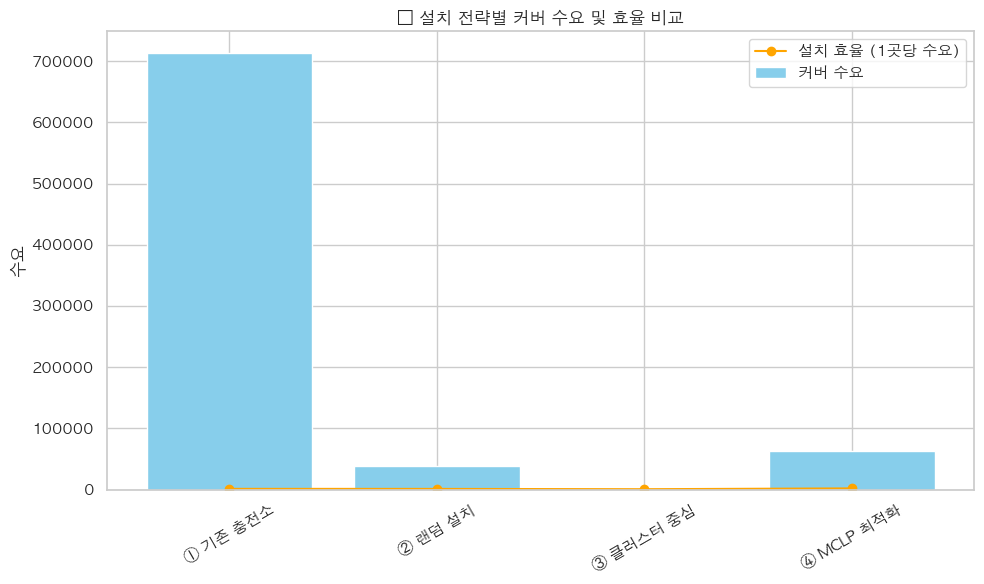

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# ✅ 한글 폰트 설정 (OS에 맞게 선택)
mpl.rcParams['font.family'] = 'AppleGothic'  # macOS
# mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows
mpl.rcParams['axes.unicode_minus'] = False

df = results.copy()
df['selected'] = df['selected'].fillna(df['covered_grids'])

plt.figure(figsize=(10, 6))
plt.bar(df['baseline'], df['coverage'], color='skyblue', label='커버 수요')
plt.plot(df['baseline'], df['coverage'] / df['selected'], color='orange', marker='o', label='설치 효율 (1곳당 수요)')

plt.xticks(rotation=30)
plt.ylabel("수요")
plt.title("⚡ 설치 전략별 커버 수요 및 효율 비교")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
import folium
from geopy.distance import geodesic
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0):
    """
    여러 설치 전략을 한 지도에 격자 커버리지를 색상별로 구분하여 시각화

    Parameters:
    - features: 전체 grid DataFrame (center_lat, center_lon 포함)
    - strategy_dict: {label: 설치지 DataFrame} 형식
    - radius_km: 커버 반경
    """
    # 지도 초기화 (서울 중심)
    m = folium.Map(location=[37.55, 126.98], zoom_start=11, tiles='cartodbpositron')

    # 고유 색상 설정
    color_map = {
        '① 기존 충전소': 'red',
        '② 랜덤 설치': 'green',
        '③ 클러스터 중심': 'purple',
        '④ MCLP 최적화': 'blue'
    }

    for label, install_df in strategy_dict.items():
        color = color_map[label]

        for _, grid in features.iterrows():
            grid_center = (grid['center_lat'], grid['center_lon'])
            for _, site in install_df.iterrows():
                site_center = (site['center_lat'], site['center_lon'])
                if geodesic(grid_center, site_center).km <= radius_km:
                    folium.CircleMarker(
                        location=grid_center,
                        radius=2.5,
                        color=color,
                        fill=True,
                        fill_opacity=0.3,
                        popup=f"{label} 커버"
                    ).add_to(m)
                    break

        # 설치 위치 강조
        for _, site in install_df.iterrows():
            folium.Marker(
                location=(site['center_lat'], site['center_lon']),
                icon=folium.Icon(color=color, icon='bolt', prefix='fa'),
                popup=f"{label} 설치지"
            ).add_to(m)

    return m

In [ ]:
# 기존 충전소
existing_stations_df = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
existing_stations_df = existing_stations_df.dropna(subset=['위도', '경도']).copy()
existing_stations_df = existing_stations_df.rename(columns={'위도': 'center_lat', '경도': 'center_lon'})

# MCLP 설치지
mclp_selected_df = features[features['selected'] == 1][['grid_id', 'center_lat', 'center_lon']].copy()

# 랜덤 설치
np.random.seed(42)
random_sites_df = features.sample(n=FACILITY_LIMIT)[['grid_id', 'center_lat', 'center_lon']].copy()

# 클러스터 중심 (각 클러스터마다 중심 1개씩)
cluster_center_df = features.groupby('cluster')[['center_lat', 'center_lon']].mean().reset_index()

# 전략별 dict
strategy_dict = {
    "① 기존 충전소": existing_stations_df,
    "② 랜덤 설치": random_sites_df,
    "③ 클러스터 중심": cluster_center_df,
    "④ MCLP 최적화": mclp_selected_df
}

# 지도 생성 및 저장
map_all = plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0)
map_all.save("../outputs/maps/coverage_comparison_map.html")
map_all